In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import cm
from tqdm import tqdm
import seaborn as sns

# Univariate data

In this section, we simulate univariate data from a Gaussian law.

We want to estimate the expectancy of the law (very tractable in this case because we know all the moments of the normal law).

In the first case, we use the first estimator that we recall, for convenience :

\begin{equation*}
  \frac{1}{p_X} \sum_{i=1}^n X_i 1_{\{I_i = 1\}}
\end{equation*}

In the second case, we use the following estimator :

\begin{equation*}
  \frac{1}{\sum_{i=1}^n 1_{\{I_i = 1\}}} \sum_{i=1}^n X_i 1_{\{I_i = 1\}}
\end{equation*}

In [ ]:
def estimate(data, missing, know):
    data = np.multiply(data, missing)
    if know :
        output = np.sum(data) / (data.shape[0] * target['presence'])
    else :
        output = np.sum(data) / (np.sum(missing))

    return output

def simu(target, know = True):
    output = []

    for k in range(target['niter']):
        probs = []
        estimator_store = np.zeros(len(target['n_sample']))
        obs_all = target['simulation'](np.max(target['n_sample']))
        I = np.transpose(np.random.binomial(1,target['presence'], np.max(target['n_sample'])))
        obs_all = np.transpose(np.reshape([obs_all, I], (2, np.max(target['n_sample']))))
        for i in range(0, len(target['n_sample'])) :
            obs = obs_all[:target['n_sample'][i]]
            estimator = estimate(obs[:,0], obs[:,1], know)
            estimator_store[i] = estimator
            probs.append(target['presence'])

        output_cbind = np.c_[estimator_store, target['n_sample'], np.arange(len(target['n_sample'])),probs]
        output.append(output_cbind)
    return output

def var_missing(p_x, m, sigma):
    value = (p_x**-1)*(sigma**2 + m**2) - m**2
    return value

def var_miss(p_x, sigma):
    value = (p_x**-1)*(sigma**2)
    return value

def gauss_function(x, x0, sigma):
    return np.sqrt(1 / (2*np.pi * sigma**2)) * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2) )

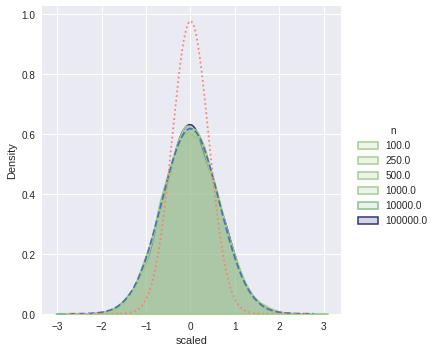

In [ ]:
target = {}

def rand(n):
  sample = np.random.uniform(0,1,n)
  return sample

target['niter'] = 10000
target['simulation'] = rand
target['presence'] = 0.5
target['n_sample'] = [100,250,500,1000,10000,100000]

mean = 1/2
cov = np.sqrt(1/12)
	
dataset = simu(target, know = True)
df_FMado = pd.DataFrame(np.concatenate(dataset))
df_FMado.columns = ['estimate', 'n', 'gp', 'prob']

df_FMado['scaled'] = (df_FMado.estimate - mean) * np.sqrt(df_FMado.n)
m = 0
sigma = np.sqrt(var_missing(target['presence'], mean, cov))
sigma_2 = np.sqrt(var_miss(target['presence'], cov))
x = np.linspace(min(df_FMado['scaled']), max(df_FMado['scaled']), 1000)
gauss = gauss_function(x,m, sigma)
gauss_2 = gauss_function(x, m, sigma_2)

cmap = cm.get_cmap('OrRd')
sns.displot(data = df_FMado, x = "scaled", hue = "n", palette= "crest", kind = 'kde', common_norm = False, alpha = 0.2, fill = True, linewidth = 1.5)
plt.plot(x,gauss, linestyle = '--')
plt.plot(x, gauss_2, c = 'salmon', linestyle = 'dotted')
plt.show()

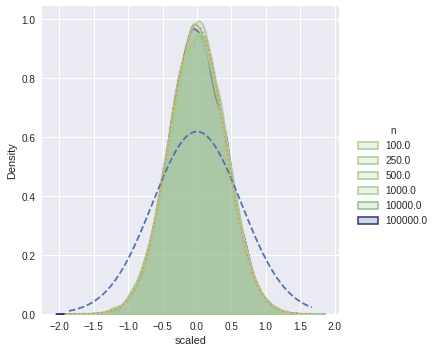

In [ ]:
target = {}

def rand(n):
  sample = np.random.uniform(0,1,n)
  return sample

target['niter'] = 10000
target['simulation'] = rand
target['presence'] = 0.5
target['n_sample'] = [100,250,500,1000,10000,100000]

mean = 1/2
cov = np.sqrt(1/12)
	
dataset = simu(target, know = False)
df_FMado = pd.DataFrame(np.concatenate(dataset))
df_FMado.columns = ['estimate', 'n', 'gp', 'prob']

df_FMado['scaled'] = (df_FMado.estimate - mean) * np.sqrt(df_FMado.n)
m = 0
sigma = np.sqrt(var_missing(target['presence'], mean, cov))
sigma_2 = np.sqrt(var_miss(target['presence'], cov))
x = np.linspace(min(df_FMado['scaled']), max(df_FMado['scaled']), 1000)
gauss = gauss_function(x,m, sigma)
gauss_2 = gauss_function(x, m, sigma_2)

cmap = cm.get_cmap('OrRd')
sns.displot(data = df_FMado, x = "scaled", hue = "n", palette= "crest", kind = 'kde', common_norm = False, alpha = 0.2, fill = True, linewidth = 1.5)
plt.plot(x,gauss, linestyle = '--')
plt.plot(x, gauss_2, c = 'salmon', linestyle = 'dotted')
plt.show()

# Bivariate vector

Here, we simulate a bivariate vector from (X,Y) where X and Y are independent and $X \sim \mathcal{E}(2)$ and $Y \sim \mathcal{E}(3)$.

Nous voulons estimer la quantité $\mathbb{E}[min(X,Y)]$ (qui est une loi exponentielle de paramètre 5).

Some data are missing in the observations $X_i$ $i \in \{1, \dots, n\}$ with probability p_X > 0, same for observations $Y_i$ with $i \in \{1, \dots, n\}$.

The first estimator is given by

\begin{equation*}
  \frac{1}{p_{XY}} \sum_{i=1}^n min(X_i, Y_i) 1_{\{I_i = 1, J_i = 1\}}
\end{equation*}

The second estimator is given by :

\begin{equation*}
  \frac{1}{\sum_{i=1}^n  1_{\{I_i = 1, J_i = 1\}}} \sum_{i=1}^n min(X_i, Y_i) 1_{\{I_i = 1, J_i = 1\}}
\end{equation*}


In [ ]:
def rand(n):
  sample = np.zeros([n,2])
  sample[:,0] = np.random.exponential(1/2, n)
  sample[:,1] = np.random.exponential(1/3, n)
  return sample

def observation(presence, randomness):
  ncol = randomness.shape[1]
  nrow = randomness.shape[0]
  output = randomness
  for p in range(0, ncol):
    indicators = np.random.binomial(1, presence[p],nrow)
    output = np.column_stack((output, indicators))

  min_ = np.minimum(output[:,0], output[:,1])
  cross_ = np.multiply(output[:,2], output[:,3])
  output = np.column_stack((min_, cross_))

  return output

def estimate(data, missing, know):
    data = np.multiply(data, missing)
    if know :
        output = np.sum(data) / (data.shape[0] * (target['presence'][0] * target['presence'][1]))
    else :
        output = np.sum(data) / (np.sum(missing))

    return output

def simu(target, know = True):
    output = []
    for k in range(target['niter']):
        probs = []
        estimator_store = np.zeros(len(target['n_sample']))
        randomness = target['simulation'](np.max(target['n_sample']))
        obs_all = target['observation'](target['presence'], randomness)
        for i in range(0, len(target['n_sample'])) :
            obs = obs_all[:target['n_sample'][i]]
            estimator = estimate(obs[:,0], obs[:,1], know)
            estimator_store[i] = estimator
            probs.append(target['presence'])

        output_cbind = np.c_[estimator_store, target['n_sample'], np.arange(len(target['n_sample'])),probs]
        output.append(output_cbind)
    return output

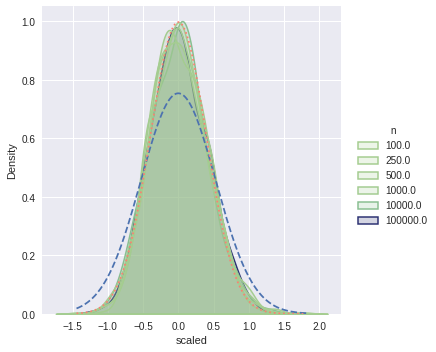

In [ ]:
target = {}

target['niter'] = 1000
target['simulation'] = rand
target['observation'] = observation
target['presence'] = [0.5,0.5]
target['n_sample'] = [100,250,500,1000,10000,100000]

mean = 1/5
cov = np.sqrt(1/25)

dataset = simu(target, know = False)
df_FMado = pd.DataFrame(np.concatenate(dataset))
df_FMado.columns = ['estimate', 'n', 'gp', 'p_X', 'p_Y']

df_FMado['scaled'] = (df_FMado.estimate - mean) * np.sqrt(df_FMado.n)
m = 0
sigma = np.sqrt(var_missing(target['presence'][0] * target['presence'][1], mean, cov))
sigma_2 = np.sqrt(var_miss(target['presence'][0] * target['presence'][1], cov))
x = np.linspace(min(df_FMado['scaled']), max(df_FMado['scaled']), 1000)
gauss = gauss_function(x,m, sigma)
gauss_2 = gauss_function(x, m, sigma_2)

cmap = cm.get_cmap('OrRd')
sns.displot(data = df_FMado, x = "scaled", hue = "n", palette= "crest", kind = 'kde', common_norm = False, alpha = 0.2, fill = True, linewidth = 1.5)
plt.plot(x,gauss, linestyle = '--')
plt.plot(x, gauss_2, c = 'salmon', linestyle = 'dotted')
plt.show()

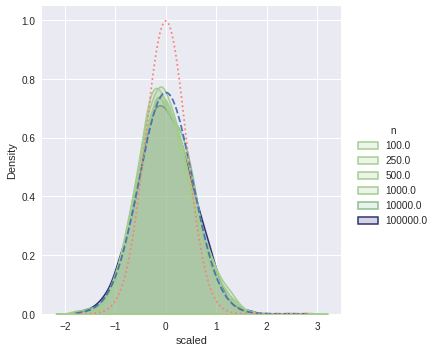

In [ ]:
target = {}

target['niter'] = 1000
target['simulation'] = rand
target['observation'] = observation
target['presence'] = [0.5,0.5]
target['n_sample'] = [100,250,500,1000,10000,100000]

mean = 1/5
cov = np.sqrt(1/25)

dataset = simu(target, know = True)
df_FMado = pd.DataFrame(np.concatenate(dataset))
df_FMado.columns = ['estimate', 'n', 'gp', 'p_X', 'p_Y']

df_FMado['scaled'] = (df_FMado.estimate - mean) * np.sqrt(df_FMado.n)
m = 0
sigma = np.sqrt(var_missing(target['presence'][0] * target['presence'][1], mean, cov))
sigma_2 = np.sqrt(var_miss(target['presence'][0] * target['presence'][1], cov))
x = np.linspace(min(df_FMado['scaled']), max(df_FMado['scaled']), 1000)
gauss = gauss_function(x,m, sigma)
gauss_2 = gauss_function(x, m, sigma_2)

cmap = cm.get_cmap('OrRd')
sns.displot(data = df_FMado, x = "scaled", hue = "n", palette= "crest", kind = 'kde', common_norm = False, alpha = 0.2, fill = True, linewidth = 1.5)
plt.plot(x,gauss, linestyle = '--')
plt.plot(x, gauss_2, c = 'salmon', linestyle = 'dotted')
plt.show()